# Correlation between Budget Grades and Repeaters


In [2]:
from school_analysis.preprocessing.load import Loader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tueplots.constants.color import rgb
import school_analysis as sa
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 200})

loader = Loader()

budget = loader.load("budgets-corrected")
grades = loader.load("abi-grades")
grades_temp = grades.T.reset_index().rename(
    columns={"level_0": "Federal State", "level_1": "Year"})
grades = pd.melt(grades_temp, id_vars=[
                 "Federal State", "Year"], value_vars=grades_temp.columns[2:], value_name="Value")
grades["Federal State"] = grades["Federal State"].map(sa.STATE_MAPPING)
grades["Year"] = grades["Year"].astype(int)
grades["Grade"] = grades["Grade"].astype(float)
repeaters = loader.load("number_of_repeaters")
repeaters = repeaters.rename(columns={"state": "Federal State", "school": "School Type",
                             "year": "Year", "total": "Repeaters", "grade": "Grade"}).drop(columns=["male", "female"])
repeaters["Repeaters"] = repeaters["Repeaters"].replace(
    "-", np.nan).dropna().astype(int)

In [3]:
grades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7936 entries, 0 to 7935
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Federal State  7936 non-null   object 
 1   Year           7936 non-null   int64  
 2   Grade          7936 non-null   float64
 3   Value          7936 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 248.1+ KB


In [4]:
def correlation(x: pd.DataFrame, y: pd.DataFrame, join_on: str = "Year", corr_column: str = "Value"):
    merged_df = pd.merge(x, y, on=join_on, suffixes=('_A', '_B'))
    display(merged_df)
    correlation_coefficient = merged_df[corr_column +
                                        '_A'].corr(merged_df[corr_column + '_B'])
    return correlation_coefficient

In [16]:
# Get the data
budget_c = budget.copy()
repeaters_c = repeaters.copy()
grades_c = grades.copy()

# Filter the data to only required columns
budget_c = budget_c.drop(columns=["Year Relative", "Index"])
budget_c_avg = budget_c.groupby(["Year"])["Reference Budget"].mean(
).reset_index()

# Correct the grades to be in the same direction as the budget
grades_c["Grade"] = grades_c["Grade"] * -1
avg_grade_state = grades_c.groupby(["Federal State", "Year"]).apply(lambda x: (
    x["Grade"] * x["Value"]).sum() / x["Value"].sum(), include_groups=False).reset_index().rename(columns={0: "Average Grade"})
avg_grade = grades_c.groupby(["Year"]).apply(lambda x: (
    x["Grade"] * x["Value"]).sum() / x["Value"].sum(), include_groups=False).reset_index().rename(columns={0: "Average Grade"})

repeaters_state = repeaters_c.groupby(["Federal State", "Year"])[
    "Repeaters"].mean().reset_index()
repeaters_avg = repeaters_c.groupby(["Year"])["Repeaters"].mean().reset_index()

## Correlation between budget budget and grades


In [17]:
# Merge the data
budget_grades_state = pd.merge(budget_c, avg_grade_state, on=[
                               "Federal State", "Year"], suffixes=('_Budget', '_Grades')).dropna().drop_duplicates()
budget_grades = pd.merge(budget_c_avg, avg_grade, on=["Year"], suffixes=(
    '_Budget', '_Grades')).dropna().drop_duplicates()

# Calculate the correlation
print("Correlation coefficient by federal state and year of average grade and reference budget ",
      np.corrcoef(budget_grades_state["Average Grade"], budget_grades_state["Reference Budget"])[0][1])
print("Correlation coefficient year of average grade and reference budget ", np.corrcoef(
    budget_grades["Average Grade"], budget_grades["Reference Budget"])[0][1])

Correlation coefficient by federal state and year of average grade and reference budget  0.43602210789031476
Correlation coefficient year of average grade and reference budget  0.8924863096930247


The correlation between budget and grades is medium for the federal states and higher for the total average grade of germany


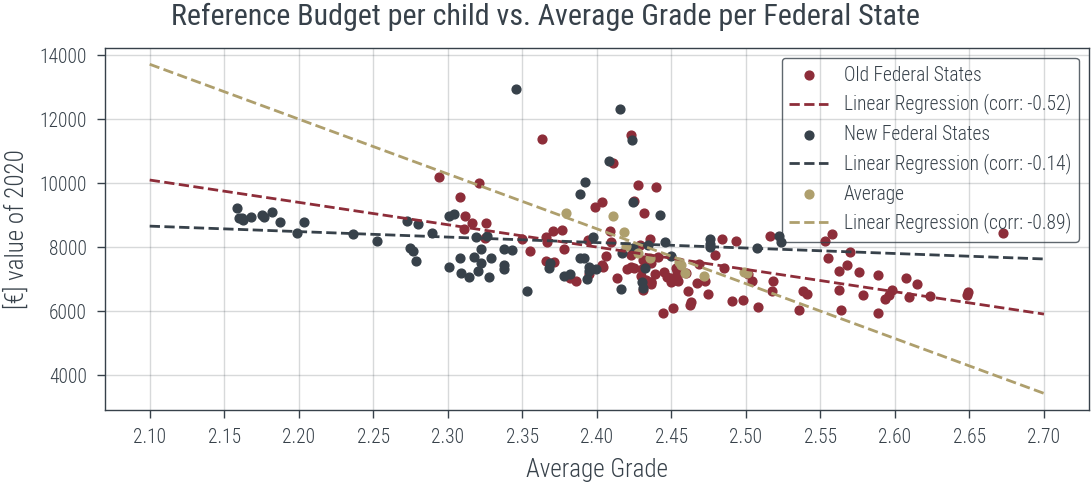

In [18]:
fig, ax = plt.subplots(1, 1)

MIN, MAX = 2.1, 2.7

for i, state in enumerate(sa.NEW_OLD_STATES_MAPPING.keys()):
    state_data = budget_grades_state[budget_grades_state["Federal State"].isin(
        sa.NEW_OLD_STATES_MAPPING[state])]
    ax.scatter(state_data["Average Grade"] * -1,
               state_data["Reference Budget"], label=state, s=10)

    # Linear regression
    corr = np.corrcoef(state_data["Average Grade"]
                       * -1, state_data["Reference Budget"])[0][1]
    X = np.vstack([np.ones(len(state_data["Average Grade"])),
                  state_data["Average Grade"] * -1]).T
    y = state_data["Reference Budget"]
    w, res, _, _ = np.linalg.lstsq(X, y, rcond=None)
    xp = np.linspace(MIN, MAX, 100)
    ax.plot(xp, w[0] + w[1] * xp, "--",
            label="Linear Regression (corr: {:.2f})".format(corr))

# Average
# Linear regression
corr = np.corrcoef(budget_grades["Average Grade"]
                   * -1, budget_grades["Reference Budget"])[0][1]
X = np.vstack([np.ones(len(budget_grades["Average Grade"])),
              budget_grades["Average Grade"] * -1]).T
y = budget_grades["Reference Budget"]
w, res, _, _ = np.linalg.lstsq(X, y, rcond=None)
xp = np.linspace(MIN, MAX, 100)
ax.scatter(budget_grades["Average Grade"] * -1,
           budget_grades["Reference Budget"], label="Average", s=10)
ax.plot(xp, w[0] + w[1] * xp, "--",
        label="Linear Regression (corr: {:.2f})".format(corr))

# Settings
ax.set_xlabel("Average Grade")
ax.set_ylabel("[€] value of 2020")
ax.set_xticks(np.arange(MIN, MAX, 0.05))
ax.grid()
ax.legend()

fig.suptitle("Reference Budget per child vs. Average Grade per Federal State")
plt.show()

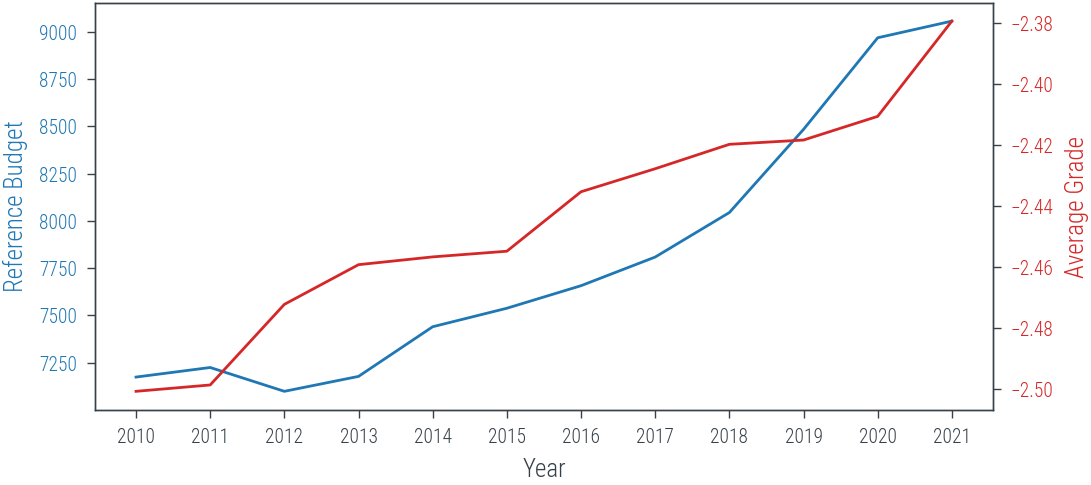

In [19]:
fig, ax1 = plt.subplots()

# Plot the data
color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Reference Budget', color=color)
ax1.plot(budget_grades["Year"], budget_grades["Reference Budget"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Grade', color=color)
ax2.plot(budget_grades["Year"], budget_grades["Average Grade"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.set_xticks(
    np.arange(budget_grades["Year"].min(), budget_grades["Year"].max() + 1, 1))

plt.show()

## Correlation between budget and repeaters


In [20]:
# Merge the data
budget_repeaters_state = pd.merge(budget_c, repeaters_state, on=[
                                  "Federal State", "Year"], suffixes=('_Budget', '_Repeaters')).dropna().drop_duplicates()
budget_repeaters = pd.merge(budget_c_avg, repeaters_avg, on=["Year"], suffixes=(
    '_Budget', '_Repeaters')).dropna().drop_duplicates()

# Calculate the correlation
print("Correlation coefficient by federal state and year of average grade and reference budget ",
      np.corrcoef(budget_repeaters_state["Repeaters"], budget_repeaters_state["Reference Budget"])[0][1])
print("Correlation coefficient year of average grade and reference budget ", np.corrcoef(
    budget_repeaters_state["Repeaters"], budget_repeaters_state["Reference Budget"])[0][1])

Correlation coefficient by federal state and year of average grade and reference budget  -0.04682884903153378
Correlation coefficient year of average grade and reference budget  -0.04682884903153378


In [21]:
def corr_plot(melted_df_state: pd.DataFrame, melted_df: pd. DataFrame, y_col: str, x_col: str, y_label: str = None, x_label: str = None, xticks: np.ndarray = None, yticks: np.ndarray = None, title: str = None, two_plots: bool = False):
    fig, axs = plt.subplots(1, 1 if not two_plots else 2,
                            sharex=True, sharey=True)

    for i, state in enumerate(sa.NEW_OLD_STATES_MAPPING.keys()):
        ax = axs if not two_plots else axs[1]
        state_data = melted_df_state[melted_df_state["Federal State"].isin(
            sa.NEW_OLD_STATES_MAPPING[state])]
        ax.scatter(state_data[x_col], state_data[y_col], label=state, s=10)

        # Linear regression
        corr = np.corrcoef(state_data[x_col], state_data[y_col])[0][1]
        X = np.vstack([np.ones(len(state_data[x_col])), state_data[x_col]]).T
        y = state_data[y_col]
        w, res, _, _ = np.linalg.lstsq(X, y, rcond=None)
        minimum = state_data[x_col].min()
        maximum = state_data[x_col].max()
        xp = np.linspace(minimum, maximum, int(abs(maximum - minimum) * 100))
        ax.plot(xp, w[0] + w[1] * xp, "--",
                label="Linear Regression (corr: {:.2f})".format(corr))

    # Average
    # Linear regression
    ax = axs if not two_plots else axs[0]
    corr = np.corrcoef(melted_df[x_col], melted_df[y_col])[0][1]
    X = np.vstack([np.ones(len(melted_df[x_col])), melted_df[x_col]]).T
    y = melted_df[y_col]
    w, res, _, _ = np.linalg.lstsq(X, y, rcond=None)
    minimum = melted_df[x_col].min()
    maximum = melted_df[x_col].max()
    xp = np.linspace(minimum, maximum, int(abs(maximum - minimum) * 100))
    ax.scatter(melted_df[x_col], melted_df[y_col], label="Average", s=10)
    ax.plot(xp, w[0] + w[1] * xp, "--",
            label="Linear Regression (corr: {:.2f})".format(corr))

    # Settings
    ax.set_ylabel(y_col if y_label is None else y_label)
    axs = [axs] if not two_plots else axs
    for ax in axs:
        ax.set_xlabel(x_col if x_label is None else x_label)
        ax.set_xticks(xticks) if xticks is not None else None
        ax.set_yticks(yticks) if yticks is not None else None
        ax.grid()
        ax.legend()

    fig.suptitle(f"{x_col} vs.  {y_col}" if title is None else title)
    plt.show()

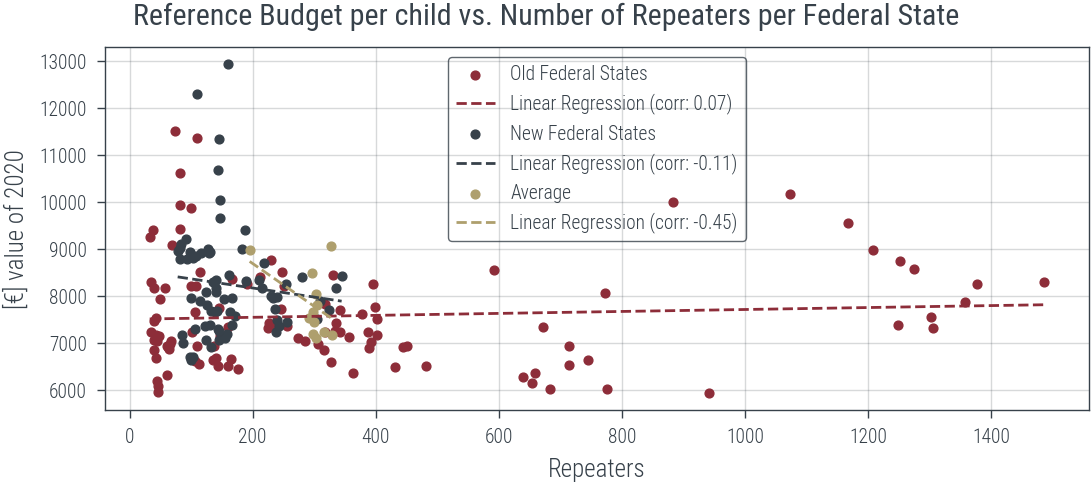

In [22]:
corr_plot(
    budget_repeaters_state,
    budget_repeaters,
    x_col="Repeaters",
    y_col="Reference Budget",
    y_label="[€] value of 2020",
    title="Reference Budget per child vs. Number of Repeaters per Federal State",
)

## Correlation between repeaters and grades


In [23]:
# Merge the data
repeaters_grades_state = pd.merge(avg_grade_state, repeaters_state, on=[
                                  "Federal State", "Year"], suffixes=('_AvgGrade', '_Repeaters')).dropna().drop_duplicates()
repeaters_grades = pd.merge(avg_grade, repeaters, on=["Year"], suffixes=(
    '_AvgGrade', '_Repeaters')).dropna().drop_duplicates()

# Calculate the correlation
print("Correlation coefficient by federal state and year of average grade and reference budget ",
      np.corrcoef(repeaters_grades_state["Repeaters"], repeaters_grades_state["Average Grade"])[0][1])
print("Correlation coefficient year of average grade and reference budget ", np.corrcoef(
    repeaters_grades["Repeaters"], repeaters_grades["Average Grade"])[0][1])

Correlation coefficient by federal state and year of average grade and reference budget  -0.03611806519761313
Correlation coefficient year of average grade and reference budget  -0.039499967052239605


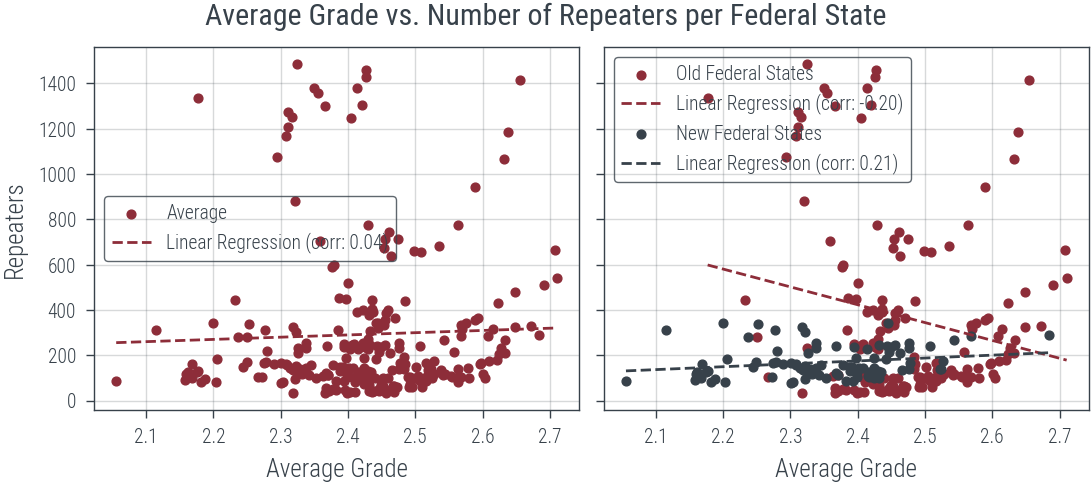

In [24]:
data = repeaters_grades_state.copy()
data["Average Grade"] = data["Average Grade"] * -1
corr_plot(
    data,
    data,
    y_col="Repeaters",
    x_col="Average Grade",
    x_label="Average Grade",
    title="Average Grade vs. Number of Repeaters per Federal State",
    two_plots=True,
)